# Ejercicio de programación 6:
# Máquinas vectoriales de soporte

## Introducción

En este ejercicio, utilizará máquinas de soporte vectorial (SVM) para crear un clasificador de spam. Antes de comenzar con el ejercicio de programación, recomendamos encarecidamente ver las video conferencias y completar las preguntas de revisión para los temas asociados.

Toda la información que necesita para resolver esta tarea está en este jupyter notebook, y todo el código que implementará tendrá lugar dentro de este jupyter notebook. La tarea se puede enviar de inmediato al evaluador de Coursera directamente desde este jupyter notebook (el código y las instrucciones se incluyen a continuación).

Antes de comenzar con los ejercicios, debemos importar todas las librerías necesarias para este ejercicio de programación. A lo largo del curso, usaremos [`numpy`] (http://www.numpy.org/) para todos los arreglos y operaciones de matriz, [` matplotlib`] (https://matplotlib.org/) para trazar, y [`scipy`] (https://docs.scipy.org/doc/scipy/reference/) para funciones y herramientas de cálculo científico y numérico.

In [55]:
# utilizado para manipular rutas de directorio
import os

# Cálculo científico y vectorial para python
import numpy as np

# Import regular expressions to process emails
import re

# Importar expresiones regulares para procesar correos electrónicos
from matplotlib import pyplot

# Módulo de optimización en scipy
from scipy import optimize

# se utilizará para cargar el formato de archivo de datos MATLAB mat
from scipy.io import loadmat

# biblioteca escrita para este ejercicio que proporciona funciones adicionales para el envío de tareas y otras
import utils

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline
from os.path import join

In [69]:
#@title
#Funciones en utils
def plotData(X, y, grid=False):
    """
    Plots the data points X and y into a new figure. Uses `+` for positive examples, and `o` for
    negative examples. `X` is assumed to be a Mx2 matrix

    Parameters
    ----------
    X : numpy ndarray
        X is assumed to be a Mx2 matrix.

    y : numpy ndarray
        The data labels.

    grid : bool (Optional)
        Specify whether or not to show the grid in the plot. It is False by default.

    Notes
    -----
    This was slightly modified such that it expects y=1 or y=0.
    """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0

    # Plot Examples
    pyplot.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    pyplot.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    pyplot.grid(grid)


def svmTrain(X, Y, C, kernelFunction, tol=1e-3, max_passes=5, args=()):
    """
    Trains an SVM classifier using a  simplified version of the SMO algorithm.

    Parameters
    ---------
    X : numpy ndarray
        (m x n) Matrix of training examples. Each row is a training example, and the
        jth column holds the jth feature.

    Y : numpy ndarray
        (m, ) A vector (1-D numpy array) containing 1 for positive examples and 0 for negative examples.

    C : float
        The standard SVM regularization parameter.

    kernelFunction : func
        A function handle which computes the kernel. The function should accept two vectors as
        inputs, and returns a scalar as output.

    tol : float, optional
        Tolerance value used for determining equality of floating point numbers.

    max_passes : int, optional
        Controls the number of iterations over the dataset (without changes to alpha)
        before the algorithm quits.

    args : tuple
        Extra arguments required for the kernel function, such as the sigma parameter for a
        Gaussian kernel.

    Returns
    -------
    model :
        The trained SVM model.

    Notes
    -----
    This is a simplified version of the SMO algorithm for training SVMs. In practice, if
    you want to train an SVM classifier, we recommend using an optimized package such as:

    - LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    - SVMLight (http://svmlight.joachims.org/)
    - scikit-learn (http://scikit-learn.org/stable/modules/svm.html) which contains python wrappers
    for the LIBSVM library.
    """
    # make sure data is signed int
    Y = Y.astype(int)
    # Dataset size parameters
    m, n = X.shape

    passes = 0
    E = np.zeros(m)
    alphas = np.zeros(m)
    b = 0

    # Map 0 to -1
    Y[Y == 0] = -1

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets
    # gracefully will **not** do this)

    # We have implemented the optimized vectorized version of the Kernels here so
    # that the SVM training will run faster
    if kernelFunction.__name__ == 'linearKernel':
        # Vectorized computation for the linear kernel
        # This is equivalent to computing the kernel on every pair of examples
        K = np.dot(X, X.T)
    elif kernelFunction.__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X2 = np.sum(X**2, axis=1)
        K = X2 + X2[:, None] - 2 * np.dot(X, X.T)

        if len(args) > 0:
            K /= 2*args[0]**2

        K = np.exp(-K)
    else:
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i, j] = kernelFunction(X[i, :], X[j, :])
                K[j, i] = K[i, j]

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            E[i] = b + np.sum(alphas * Y * K[:, i]) - Y[i]

            if (Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0):
                # select the alpha_j randomly
                j = np.random.choice(list(range(i)) + list(range(i+1, m)), size=1)[0]

                E[j] = b + np.sum(alphas * Y * K[:, j]) - Y[j]

                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]

                if Y[i] == Y[j]:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                else:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]

                # objective function positive definite, there will be a minimum along the direction
                # of linear equality constrain, and eta will be greater than zero
                # we are actually computing -eta here (so we skip of eta >= 0)
                if eta >= 0:
                    continue

                alphas[j] -= Y[j] * (E[i] - E[j])/eta
                alphas[j] = max(L, min(H, alphas[j]))

                if abs(alphas[j] - alpha_j_old) < tol:
                    alphas[j] = alpha_j_old
                    continue
                alphas[i] += Y[i]*Y[j]*(alpha_j_old - alphas[j])

                b1 = b - E[i] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[i, j]

                b2 = b - E[j] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[j, j]

                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2)/2

                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    idx = alphas > 0
    model = {'X': X[idx, :],
             'y': Y[idx],
             'kernelFunction': kernelFunction,
             'b': b,
             'args': args,
             'alphas': alphas[idx],
             'w': np.dot(alphas * Y, X)}
    return model


def svmPredict(model, X):
    """
    Returns a vector of predictions using a trained SVM model.

    Parameters
    ----------
    model : dict
        The parameters of the trained svm model, as returned by the function svmTrain

    X : array_like
        A (m x n) matrix where each example is a row.

    Returns
    -------
    pred : array_like
        A (m,) sized vector of predictions {0, 1} values.
    """
    # check if we are getting a vector. If so, then assume we only need to do predictions
    # for a single example
    if X.ndim == 1:
        X = X[np.newaxis, :]

    m = X.shape[0]
    p = np.zeros(m)
    pred = np.zeros(m)

    if model['kernelFunction'].__name__ == 'linearKernel':
        # we can use the weights and bias directly if working with the linear kernel
        p = np.dot(X, model['w']) + model['b']
    elif model['kernelFunction'].__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X1 = np.sum(X**2, 1)
        X2 = np.sum(model['X']**2, 1)
        K = X2 + X1[:, None] - 2 * np.dot(X, model['X'].T)

        if len(model['args']) > 0:
            K /= 2*model['args'][0]**2

        K = np.exp(-K)
        p = np.dot(K, model['alphas']*model['y']) + model['b']
    else:
        # other non-linear kernel
        for i in range(m):
            predictions = 0
            for j in range(model['X'].shape[0]):
                predictions += model['alphas'][j] * model['y'][j] \
                               * model['kernelFunction'](X[i, :], model['X'][j, :])
            p[i] = predictions

    pred[p >= 0] = 1
    return pred


def linearKernel(x1, x2):
    """
    Returns a linear kernel between x1 and x2.

    Parameters
    ----------
    x1 : numpy ndarray
        A 1-D vector.

    x2 : numpy ndarray
        A 1-D vector of same size as x1.

    Returns
    -------
    : float
        The scalar amplitude.
    """
    return np.dot(x1, x2)


def visualizeBoundaryLinear(X, y, model):
    """
    Plots a linear decision boundary learned by the SVM.

    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).

    y : array_like
        (m, ) The data labels.

    model : dict
        Dictionary of model variables learned by SVM.
    """
    w, b = model['w'], model['b']
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plotData(X, y)
    pyplot.plot(xp, yp, '-b')


def visualizeBoundary(X, y, model):
    """
    Plots a non-linear decision boundary learned by the SVM and overlays the data on it.

    Parameters
    ----------
    X : array_like
        (m x 2) The training data with two features (to plot in a 2-D plane).

    y : array_like
        (m, ) The data labels.

    model : dict
        Dictionary of model variables learned by SVM.
    """
    plotData(X, y)

    # make classification predictions over a grid of values
    x1plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    x2plot = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)

    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = svmPredict(model, this_X)

    pyplot.contour(X1, X2, vals, colors='y', linewidths=2)
    pyplot.pcolormesh(X1, X2, vals, cmap='YlGnBu', alpha=0.25, edgecolors='None', lw=0)
    pyplot.grid(False)


def getVocabList():
    """
    Reads the fixed vocabulary list in vocab.txt and returns a cell array of the words
    %   vocabList = GETVOCABLIST() reads the fixed vocabulary list in vocab.txt
    %   and returns a cell array of the words in vocabList.

    :return:
    """
    vocabList = np.genfromtxt(join('Data', 'vocab.txt'), dtype=object)
    return list(vocabList[:, 1].astype(str))


class PorterStemmer:
    """
    Porter Stemming Algorithm

    This is the Porter stemming algorithm, ported to Python from the
    version coded up in ANSI C by the author. It may be be regarded
    as canonical, in that it follows the algorithm presented in

    Porter, 1980, An algorithm for suffix stripping, Program, Vol. 14,
    no. 3, pp 130-137,

    only differing from it at the points maked --DEPARTURE-- below.

    See also http://www.tartarus.org/~martin/PorterStemmer

    The algorithm as described in the paper could be exactly replicated
    by adjusting the points of DEPARTURE, but this is barely necessary,
    because (a) the points of DEPARTURE are definitely improvements, and
    (b) no encoding of the Porter stemmer I have seen is anything like
    as exact as this version, even with the points of DEPARTURE!

    Vivake Gupta (v@nano.com)

    Release 1: January 2001

    Further adjustments by Santiago Bruno (bananabruno@gmail.com)
    to allow word input not restricted to one word per line, leading
    to:

    release 2: July 2008
    """
    def __init__(self):
        """
        The main part of the stemming algorithm starts here.
        b is a buffer holding a word to be stemmed. The letters are in b[k0],
        b[k0+1] ... ending at b[k]. In fact k0 = 0 in this demo program. k is
        readjusted downwards as the stemming progresses. Zero termination is
        not in fact used in the algorithm.

        Note that only lower case sequences are stemmed. Forcing to lower case
        should be done before stem(...) is called.
        """
        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        """cons(i) is TRUE <=> b[i] is a consonant."""
        if self.b[i] in 'aeiou':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return not self.cons(i - 1)
        return 1

    def m(self):
        """
        m() measures the number of consonant sequences between k0 and j.
        if c is a consonant sequence and v a vowel sequence, and <..>
        indicates arbitrary presence,

           <c><v>       gives 0
           <c>vc<v>     gives 1
           <c>vcvc<v>   gives 2
           <c>vcvcvc<v> gives 3
           ....
        """
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """ doublec(j) is TRUE <=> j,(j-1) contain a double consonant. """
        if j < (self.k0 + 1):
            return 0
        if self.b[j] != self.b[j-1]:
            return 0
        return self.cons(j)

    def cvc(self, i):
        """
        cvc(i) is TRUE <=> i-2,i-1,i has the form consonant - vowel - consonant
        and also if the second c is not w,x or y. this is used when trying to
        restore an e at the end of a short  e.g.

           cav(e), lov(e), hop(e), crim(e), but
           snow, box, tray.
        """
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch in 'wxy':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        """step1ab() gets rid of plurals and -ed or -ing. e.g.

           caresses  ->  caress
           ponies    ->  poni
           ties      ->  ti
           caress    ->  caress
           cats      ->  cat

           feed      ->  feed
           agreed    ->  agree
           disabled  ->  disable

           matting   ->  mat
           mating    ->  mate
           meeting   ->  meet
           milling   ->  mill
           messing   ->  mess

           meetings  ->  meet
        """
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):
                self.setto("ate")
            elif self.ends("bl"):
                self.setto("ble")
            elif self.ends("iz"):
                self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch in 'lsz':
                    self.k += 1
            elif self.m() == 1 and self.cvc(self.k):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if self.ends("y") and self.vowelinstem():
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        """step2() maps double suffices to single ones.
        so -ization ( = -ize plus -ation) maps to -ize etc. note that the
        string before the suffix must give m() > 0.
        """
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context <c>vcvc<v>."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i=0, j=None):
        """In stem(p,i,j), p is a char pointer, and the string to be stemmed
        is from p[i] to p[j] inclusive. Typically i is zero and j is the
        offset to the last character of a string, (p[j+1] == '\0'). The
        stemmer adjusts the characters p[i] ... p[j] and returns the new
        end-point of the string, k. Stemming never increases word length, so
        i <= k <= j. To turn the stemmer into a module, declare 'stem' as
        extern, and delete the remainder of this file.
        """
        # copy the parameters into statics
        self.b = p
        self.k = j or len(p) - 1
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b  # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]



## Temas


| Section | Part                                             
| :-      |:-                                                
| 1       | [Gaussian Kernel](#section1)                     
| 2       | [Parameters (C, $\sigma$) for Dataset 3](#section2)
| 3       | [Email Preprocessing](#section3)                 
| 4       | [Email Feature Extraction](#section4)            


## 1 Máquinas de soporte vectorial

En la primera mitad de este ejercicio, utilizará máquinas de soporte vectorial (SVM) con varios conjuntos de datos 2D de ejemplo. Experimentar con estos conjuntos de datos le ayudará a tener una idea de cómo funcionan las SVM y cómo utilizar un kernel gaussiano con SVM. En la siguiente mitad del ejercicio, utilizará máquinas de soporte vectorial para construir un clasificador de spam.

### 1.1 Ejemplo de conjunto de datos 1

Comenzaremos con un conjunto de datos de ejemplo 2D que puede estar separado por un límite lineal. La siguiente celda grafica los datos de entrenamiento, que deberían verse así:

! [Datos de entrenamiento del conjunto de datos 1] (Figures/dataset1.png)

En este conjunto de datos, las posiciones de los ejemplos positivos (indicados con "x") y los ejemplos negativos (indicados con "o") sugieren una separación natural indicada por el espacio. Sin embargo, observe que hay un ejemplo positivo atípico `x` en el extremo izquierdo aproximadamente (0.1, 4.1). Como parte de este ejercicio, también verá cómo este valor atípico afecta el límite de decisión de SVM.

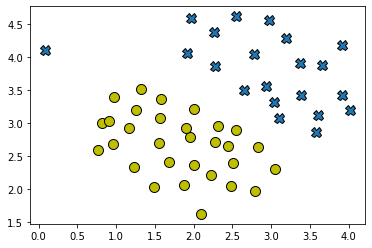

In [33]:
# Cargar los datos desde ex6data1
# Tendrá X, y como claves en el dict data
data = loadmat(os.path.join('Data', 'ex6data1.mat'))
X, y = data['X'], data['y'][:, 0]

# Graficar los datos de entrenamiento
plotData(X, y)

En esta parte del ejercicio, intentará utilizar diferentes valores del parámetro $ C $ con SVM. De manera informal, el parámetro $ C $ es un valor positivo que controla la penalización para los ejemplos de entrenamiento mal clasificados. Un parámetro $ C $ grande le dice a la SVM que intente clasificar todos los ejemplos correctamente. $ C $ juega un papel similar a $ 1 / \lambda $, donde $ \lambda $ es el parámetro de regularización que estábamos usando anteriormente para la regresión logística.


La siguiente celda ejecutará el entrenamiento SVM (con $ C = 1 $) usando el software SVM que hemos incluido con el código de inicio (función `svmTrain` dentro del módulo` utils` de este ejercicio). Cuando $ C = 1 $, debería encontrar que la SVM coloca el límite de decisión en la brecha entre los dos conjuntos de datos y *clasifica erróneamente* el punto de datos en el extremo izquierdo, como se muestra en la figura (izquierda) a continuación.

<table style="text-align:center">
    <tr>
        <th colspan="2" style="text-align:center">SVM Decision boundary for example dataset 1 </th>
    </tr>
    <tr>
        <td style="text-align:center">C=1<img src="Figures/svm_c1.png"/></td>
        <td style="text-align:center">C=100<img src="Figures/svm_c100.png"/></td>
    </tr>
</table>

<div class="alert alert-block alert-warning">
Para minimizar la dependencia de librerías externas, hemos incluido un algoritmo de aprendizaje SVM en utils.svmTrain. Sin embargo, esta implementación en particular no es muy eficiente (originalmente se eligió para maximizar la compatibilidad entre Octave / MATLAB para la primera versión de este conjunto de asignaciones). Si está entrenando a un SVM sobre un problema real, especialmente si necesita escalar a un conjunto de datos más grande, le recomendamos que utilice una caja de herramientas SVM altamente optimizada como [LIBSVM] (https://www.csie.ntu.edu. tw / ~ cjlin / libsvm /). La biblioteca de aprendizaje automático de Python [scikit-learn] (http://scikit-learn.org/stable/index.html) proporciona contenedores para la biblioteca LIBSVM.
</div>
<br/>
<div class = "alerta alerta-bloque alerta-advertencia">
** Nota de implementación: ** La mayoría de los paquetes de software SVM (incluida la función `utils.svmTrain`) agregan automáticamente la función adicional $ x_0 $ = 1 y se encargan automáticamente de aprender el término de intercepción $ \ theta_0 $. Por lo tanto, al pasar sus datos de entrenamiento al software SVM, no es necesario que agregue esta función adicional $ x_0 = 1 $ usted mismo. En particular, en Python su código debería funcionar con ejemplos de entrenamiento $ x \ in \ mathcal {R} ^ n $ (en lugar de $ x \ in \ mathcal {R} ^ {n + 1} $); por ejemplo, en el primer conjunto de datos de ejemplo $ x \ in \ mathcal {R} ^ 2 $.
</div>

Su tarea es probar diferentes valores de $ C $ en este conjunto de datos. Específicamente, debe cambiar el valor de $ C $ en la siguiente celda a $ C = 100 $ y ejecutar el entrenamiento de SVM nuevamente. Cuando $ C = 100 $, debería encontrar que la SVM ahora clasifica cada ejemplo correctamente, pero tiene un límite de decisión que no parece ser un ajuste natural para los datos.

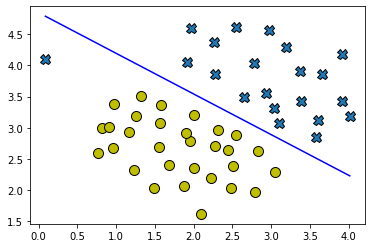

In [34]:
# Debería intentar cambiar el valor C a continuación y ver cómo el límite
# de decisión varian (e.g., try C = 1000)
C = 1

model = svmTrain(X, y, C, linearKernel, 1e-3, 20)
visualizeBoundaryLinear(X, y, model)

<a id="section1"></a>
### 1.2 SVM con kernels gaussianos

En esta parte del ejercicio, utilizará SVM para realizar una clasificación no lineal. En particular, utilizará SVM con kernels gaussianos en conjuntos de datos que no se pueden separar linealmente.

#### 1.2.1 Kernel gaussiano

Para encontrar límites de decisión no lineales con la SVM, primero debemos implementar un kernel gaussiano. Puede pensar en el kernel gaussiano como una función de similitud que mide la "distancia" entre un par de ejemplos,
($ x ^ {(i)} $, $ x ^ {(j)} $). El kernel gaussiano también está parametrizado por un parámetro de ancho de banda, $ \ sigma $, que determina qué tan rápido disminuye la métrica de similitud (a 0) a medida que los ejemplos están más separados.
Ahora debería completar el código en `gaussianKernel` para calcular el kernel gaussiano entre dos ejemplos, ($ x ^ {(i)} $, $ x ^ {(j)} $). La función del kernel de Gauss se define como:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$
<a id="gaussianKernel"></a>

In [35]:
def gaussianKernel(x1, x2, sigma):
    """
    Calcula la función de base radial
     Devuelve un kernel de función de base radial entre x1 y x2.
    
     Parámetros
     ----------
     x1: numpy ndarray
         Un vector de tamaño (n,), que representa el primer punto de datos.
    
     x2: numpy ndarray
         Un vector de tamaño (n,), que representa el segundo punto de datos.
    
     sigma: float
         El parámetro de ancho de banda para el kernel gaussiano.

     Retorna
     -------
     sim: float
         El RBF calculado entre los dos puntos de datos proporcionados.
    
     Instrucciones
     ------------
     Complete esta función para devolver la similitud entre `x1` y` x2`
     calculado usando un kernel gaussiano con ancho de banda "sigma".
    """
    sim = 0
    # ====================== YOUR CODE HERE ======================

    sim = np.exp(-np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2)))

    # =============================================================
    return sim

Una vez que haya completado la función `gaussianKernel`, la siguiente celda probará la función con dos ejemplos proporcionados y debería esperar ver un valor de 0.324652.

In [36]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



### 1.2.2 Ejemplo de conjunto de datos 2

La siguiente parte de este jupyter notebook cargará y graficará el conjunto de datos 2, como se muestra en la figura siguiente.

![Dataset 2](Figures/dataset2.png)

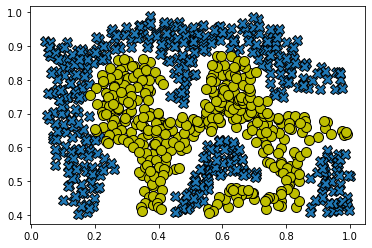

In [37]:
# Cargar desde ex6data2
# Tendrás X, y como claves en el dict data
data = loadmat(os.path.join('Data', 'ex6data2.mat'))
X, y = data['X'], data['y'][:, 0]

# Graficar datos de entrenamiento
plotData(X, y)

En la figura, puede observar que no existe un límite de decisión lineal que separe los ejemplos positivos y negativos de este conjunto de datos. Sin embargo, al usar el kernel gaussiano con SVM, podrá aprender un límite de decisión no lineal que puede funcionar razonablemente bien para el conjunto de datos. Si ha implementado correctamente la función del kernel gaussiano, la siguiente celda procederá a entrenar la SVM con el kernel gaussiano en este conjunto de datos.

Debería obtener un límite de decisión como se muestra en la figura siguiente, calculado por la SVM con un kernel gaussiano. El límite de decisión puede separar correctamente la mayoría de los ejemplos positivos y negativos y sigue bien los contornos del conjunto de datos.

![Dataset 2 decision boundary](Figures/svm_dataset2.png)

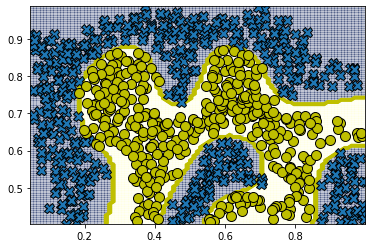

In [38]:
# SVM Parameters
C = 1
sigma = 0.1

model= svmTrain(X, y, C, gaussianKernel, args=(sigma,))
visualizeBoundary(X, y, model)

<a id="section2"></a>
#### 1.2.3 Ejemplo de conjunto de datos 3

En esta parte del ejercicio, obtendrá más habilidades prácticas sobre cómo usar una SVM con un kernel gaussiano. La siguiente celda se cargará y mostrará un tercer conjunto de datos, que debería parecerse a la figura siguiente.

![Dataset 3](Figures/dataset3.png)
Utilizará SVM con el kernel de Gauss con este conjunto de datos. En el conjunto de datos proporcionado, `ex6data3.mat`, se le dan las variables` X`, `y`,` Xval`, `yval`.

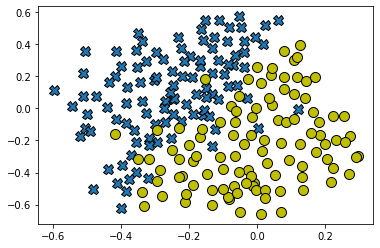

In [39]:
# Cargar desde ex6data3
# Tendrá X, y, Xval, yval como claves en el dict data
data = loadmat(os.path.join('Data', 'ex6data3.mat'))
X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

# Graficar datos de entrenamiento
plotData(X, y)

Su tarea es usar el conjunto de validación cruzada `Xval`,` yval` para determinar el mejor parámetro $ C $ y $ \ sigma $ para usar. Debe escribir cualquier código adicional necesario para ayudarlo a buscar los parámetros $ C $ y $ \ sigma $. Para $ C $ y $ \ sigma $, sugerimos probar valores en pasos multiplicativos (por ejemplo, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).
Tenga en cuenta que debe probar todos los pares de valores posibles para $ C $ y $ \ sigma $ (por ejemplo, $ C = 0.3 $ y $ \ sigma = 0.1 $). Por ejemplo, si prueba cada uno de los 8 valores enumerados anteriormente para $ C $ y $ \ sigma ^ 2 $, terminaría entrenando y evaluando (en el conjunto de validación cruzada) un total de $ 8 ^ 2 = 64 $ diferentes modelos. Después de haber determinado los mejores parámetros $ C $ y $ \ sigma $ para usar, debe modificar el código en `dataset3Params`, completando los mejores parámetros que encontró. Para nuestros mejores parámetros, la SVM devolvió un límite de decisión que se muestra en la figura siguiente.

![](Figures/svm_dataset3_best.png)

<div class="alert alert-block alert-warning">
** Sugerencia de implementación: ** Al implementar la validación cruzada para seleccionar el mejor parámetro $ C $ y $ \ sigma $ para usar, debe evaluar el error en el conjunto de validación cruzada. Recuerde que para la clasificación, el error se define como la fracción de los ejemplos de validación cruzada que se clasificaron incorrectamente. En `numpy`, puedes calcular este error usando` np.mean (predictions! = Yval) `, donde` predictions` es un vector que contiene todas las predicciones de la SVM, y `yval` son las etiquetas verdaderas de la validación cruzada conjunto. Puede utilizar la función `utils.svmPredict` para generar las predicciones para el conjunto de validación cruzada.
</div>
<a id="dataset3Params"></a>

In [51]:
def dataset3Params(X, y, Xval, yval):
    """
    Retorna la elección de C y sigma para la Parte 3 del ejercicio
    donde selecciona los parámetros de aprendizaje óptimos (C, sigma) para usar para SVM
    con kernel RBF.
    
    Parámetros
    ----------
    X: array_like
        (m x n) matriz de datos de entrenamiento donde m es el número de ejemplos de entrenamiento, y
        n es el número de funciones.
    
    y: array_like
        (m,) vector de etiquetas para otros datos de entrenamiento.
    
    Xval: array_like
        (mv x n) matriz de datos de validación donde mv es el número de ejemplos de validación
        y n es el número de características
    
    yval: array_like
        (mv,) vector de etiquetas para los datos de validación.
    
    Devoluciones
    -------
    C, sigma: float, float
        Los valores de mejor rendimiento para el parámetro de regularización C y
        Parámetro RBF sigma.
    
    Instrucciones
    ------------
    Complete esta función para devolver el aprendizaje óptimo de C y sigma
    parámetros encontrados usando el conjunto de validación cruzada.
    Puede usar `svmPredict` para predecir las etiquetas en la cruz
    conjunto de validación. Por ejemplo,
    
        predicciones = svmPredict (modelo, Xval)

    devolverá las predicciones en el conjunto de validación cruzada.
    
    Nota
    ----
    Puede calcular el error de predicción usando
    
        np.mean(predictions != yval)
    """
    # Debe retornar las siguientes variables correctamente.
    C = 1
    sigma = 0.3
    # ====================== YOUR CODE HERE ======================
    C_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])
    sigma_array = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])

    my_array = np.zeros([C_array.size, sigma_array.size])
    
    for i in np.arange(C_array.size):
        for j in np.arange(sigma_array.size):
            model= svmTrain(X, y, C_array[i], gaussianKernel, args=(sigma_array[j],))
            predictions = svmPredict(model, Xval)
            pred_error = np.mean(predictions != yval)
            my_array[i, j] = pred_error
        
    ind = np.unravel_index(np.argmin(my_array, axis = None), my_array.shape)
    C = C_array[ind[0]]
    sigma = sigma_array[ind[1]]
    
    
    # ============================================================
    return C, sigma

El código proporcionado en la siguiente celda entrena al clasificador SVM usando el conjunto de entrenamiento $ (X, y) $ usando parámetros cargados desde `dataset3Params`. Tenga en cuenta que esto puede tardar unos minutos en ejecutarse.

0.3 0.1


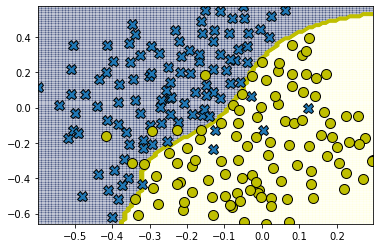

In [52]:
# Intente con diferentes parametros aqui
C, sigma = dataset3Params(X, y, Xval, yval)

# Entrene el SVM
# model = svmTrain(X, y, C, lambda x1, x2: gaussianKernel(x1, x2, sigma))
model =svmTrain(X, y, C, gaussianKernel, args=(sigma,))
visualizeBoundary(X, y, model)
print(C, sigma)

<a id="section3"></a>
## 2 Clasificación de spam

Hoy en día, muchos servicios de correo electrónico ofrecen filtros de spam que pueden clasificar los correos electrónicos en spam y no spam con gran precisión. En esta parte del ejercicio, utilizará SVM para crear su propio filtro de spam.

Entrenará a un clasificador para clasificar si un correo electrónico determinado, $ x $, es spam ($ y = 1 $) o no es spam ($ y = 0 $). En particular, debe convertir cada correo electrónico en un vector de características $ x \ in \ mathbb {R} ^ n $. Las siguientes partes del ejercicio le explicarán cómo se puede construir un vector de características de este tipo a partir de un correo electrónico.

El conjunto de datos incluido para este ejercicio se basa en un subconjunto del [Corpus público de SpamAssassin] (http://spamassassin.apache.org/old/publiccorpus/). A los efectos de este ejercicio, solo utilizará el cuerpo del correo electrónico (excluyendo los encabezados del correo electrónico).

### 2.1 Preprocesamiento de correos electrónicos

Antes de comenzar con una tarea de aprendizaje automático, suele ser útil echar un vistazo a los ejemplos del conjunto de datos. La siguiente figura muestra un ejemplo de correo electrónico que contiene una URL, una dirección de correo electrónico (al final), números y dólares
cantidades.

<img src = "Figures/email.png" width = "700px" />

Si bien muchos correos electrónicos contendrían tipos similares de entidades (por ejemplo, números, otras URL u otras direcciones de correo electrónico), las entidades específicas (por ejemplo, la URL específica o el monto específico en dólares) serán diferentes en casi todos los correos electrónicos. Por lo tanto, un método que se emplea a menudo en el procesamiento de correos electrónicos es "normalizar" estos valores, de modo que todas las URL se traten de la misma manera, todos los números se traten de la misma manera, etc. Por ejemplo, podríamos reemplazar cada URL en el
correo electrónico con la cadena única "httpaddr" para indicar que había una URL.

Esto tiene el efecto de permitir que el clasificador de spam tome una decisión de clasificación en función de si había alguna URL presente, en lugar de si estaba presente una URL específica. Por lo general, esto mejora el rendimiento de un clasificador de spam, ya que los spammers a menudo aleatorizan las URL y, por lo tanto, las probabilidades de volver a ver una URL en particular en una nueva pieza de spam son muy pequeñas.

En la función `processEmail` a continuación, hemos implementado los siguientes pasos de preprocesamiento y normalización de correo electrónico:

- ** Minúsculas **: todo el correo electrónico se convierte en minúsculas, por lo que se ignora la captura de datos (p. Ej., IndIcaTE se trata de la misma manera que Indicate).

- ** Eliminación de HTML **: todas las etiquetas HTML se eliminan de los correos electrónicos. Muchos correos electrónicos a menudo vienen con formato HTML; eliminamos todas las etiquetas HTML, de modo que solo quede el contenido.

- ** Normalización de URL **: todas las URL se reemplazan con el texto "httpaddr".

- ** Normalización de direcciones de correo electrónico **: todas las direcciones de correo electrónico se reemplazan con el texto "emailaddr".

- ** Normalización de números **: Todos los números se reemplazan con el texto "number".

- ** Normalización de dólares **: Todos los signos de dólar ($) se reemplazan con el texto "dollar".

- ** Palabras derivadas (stemming) **: las palabras se reducen a su forma raíz. Por ejemplo, "descuento", "descuentos", "descontado" y "descuento" se reemplazan por "descuento". A veces, Stemmer elimina los caracteres adicionales del final, por lo que "incluir", "incluye", "incluido" e "incluido" se reemplazan por "incluido".

- ** Eliminación de concetores **: Se han eliminado los concetores y la puntuación. Todos los espacios en blanco (tabulaciones, nuevas líneas, espacios) se han recortado a un solo carácter de espacio.

El resultado de estos pasos de preprocesamiento se muestra en la siguiente figura.

<img src = "Figures / email_cleaned.png" alt = "correo electrónico limpiado" style = "width: 600px;" />

Si bien el preprocesamiento ha dejado fragmentos de palabras y no palabras, resulta mucho más fácil trabajar con esta forma para realizar la extracción de características.

#### 2.1.1 Lista de vocabulario

Después de preprocesar los correos electrónicos, tenemos una lista de palabras para cada correo electrónico. El siguiente paso es elegir qué palabras nos gustaría usar en nuestro clasificador y cuáles quisiéramos omitir.

Para este ejercicio, hemos elegido solo las palabras que aparecen con más frecuencia como nuestro conjunto de palabras consideradas (la lista de vocabulario). Dado que las palabras que aparecen con poca frecuencia en el conjunto de entrenamiento se encuentran solo en unos pocos correos electrónicos,
modelo para adaptarse a nuestro conjunto de entrenamiento. La lista completa de vocabulario está en el archivo `vocab.txt` (dentro del directorio` Data` para este ejercicio) y también se muestra en la figura siguiente.

<img src = "Figures / vocab.png" alt = "Vocab" width = "150px" />

Nuestra lista de vocabulario se seleccionó eligiendo todas las palabras que aparecen al menos 100 veces en el cuerpo de spam,
resultando en una lista de 1899 palabras. En la práctica, a menudo se utiliza una lista de vocabulario de entre 10.000 y 50.000 palabras.
Dada la lista de vocabulario, ahora podemos asignar cada palabra en los correos electrónicos preprocesados ​​en una lista de índices de palabras que contiene el índice de la palabra en el diccionario. La siguiente figura muestra la asignación del correo electrónico de muestra. Específicamente, en el correo electrónico de muestra, la palabra "cualquiera" se normalizó primero a "cualquier" y luego se asignó al índice 86 en la lista de vocabulario.

<img src = "Figures / word_indices.png" alt = "índices de palabras" width = "200px" />

Tu tarea ahora es completar el código en la función `processEmail` para realizar este mapeo. En el código, se le da una cadena "word" que es una sola palabra del correo electrónico procesado. Debería buscar la palabra en la lista de vocabulario `vocabList`. Si la palabra existe en la lista, debe agregar el índice de la palabra en la variable `word_indices`. Si la palabra no existe y, por lo tanto, no está en el vocabulario, puede omitirla.

<div class = "alerta alerta-bloque alerta-advertencia">
** consejo de Python **: en Python, puede encontrar el índice de la primera aparición de un elemento en la `list` usando el atributo` index`. En el código proporcionado para `processEmail`,` vocabList` es una lista de Python que contiene las palabras del vocabulario. Para encontrar el índice de una palabra, podemos usar `vocabList.index (word)` que devolvería un número que indica el índice de la palabra dentro de la lista. Si la palabra no existe en la lista, se genera una excepción "ValueError". En Python, podemos usar la instrucción `try / except` para detectar excepciones que no queremos detener la ejecución del programa. Puede pensar que la declaración `try / except` es lo mismo que una declaración` if / else`, pero pide perdón en lugar de permiso.

Un ejemplo sería:
<br>

''
tratar:
    hacer cosas aquí
excepto ValueError:
    pasar
    # no haga nada (perdóneme) si se produjo una excepción ValueError dentro de la función try
''
</div>
<a id="processEmail"> </a>

In [56]:
def processEmail(email_contents, verbose=True):
    """
   Preprocesa el cuerpo de un correo electrónico y devuelve una lista de índices
    de las palabras contenidas en el correo electrónico.
    
    Parámetros
    ----------
    email_contents: str
        Una cadena que contiene un correo electrónico.
    
    detallado: bool
        Si es Verdadero, imprima el correo electrónico resultante después de procesarlo.
    
    Retorna
    -------
    indices_palabras: lista
        Una lista de enteros que contiene el índice de cada palabra en el
        correo electrónico que también está presente en el vocabulario.
    
    Instrucciones
    ------------
    Complete esta función para agregar el índice de palabra a word_indices
    si está en el vocabulario. En este punto del código, tienes
    una palabra raíz del correo electrónico en la palabra variable.
    Debería buscar palabra en la lista de vocabulario (vocabList).
    Si existe una coincidencia, debe agregar el índice de la palabra a word_indices
    lista. Concretamente, si palabra = 'action', entonces debería
    buscar la lista de vocabulario para encontrar dónde en vocabList
    Aparece 'action'. Por ejemplo, si vocabList [18] =
    'action', entonces, debes agregar 18 a word_indices
    vector (por ejemplo, word_indices.append (18)).
    
    Notas
    -----
    - vocabList [idx] devuelve la palabra con el índice idx en la lista de vocabulario.
    
    - vocabList.index (word) devuelve el índice de la palabra `word` en la lista de vocabulario.
      (Se genera una excepción ValueError si la palabra no existe).
    """
    # Carga el vocabulario
    vocabList = getVocabList()

    # Valor inicial para retornar
    word_indices = []

    # ========================== Preprocess Email ===========================
      # Encuentra los encabezados (\n\n y elimínalos)
     # Descomente las siguientes líneas si está trabajando con correos electrónicos sin procesar con el
     # encabezados completos
     # hdrstart = email_contents.find (chr (10) + chr (10))
     # email_contents = email_contents [hdrstart:]

    # Letras minusculas
    email_contents = email_contents.lower()
    
    # Elimina todo el HTML
     # Busca cualquier expresión que comience con <y termine con> y reemplace
     # y no tiene <or> en la etiqueta con un espacio
    email_contents =re.compile('<[^<>]+>').sub(' ', email_contents)

    # Manejar números
    # Busque uno o más caracteres entre 0-9
    email_contents = re.compile('[0-9]+').sub(' number ', email_contents)

    # Manejar URLS
     # Busque cadenas que comiencen con http:// o https://
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)

    # Manejar direcciones de correo electrónico
    # Busque cadenas con @ en el medio
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)
    
    # Manejar el signo $
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)
    
    # deshacerse de los signos de puntuación
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)

    # eliminar cualquier cadena de palabras vacía
    email_contents = [word for word in email_contents if len(word) > 0]
    
    # Sacar la raiz a cada palabra
    stemmer = PorterStemmer()
    processed_email = []
    for word in email_contents:
        # Eliminar cualquier carácter no alfanumérico restante
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)

        if len(word) < 1:
            continue

        # Busque la palabra en el diccionario y agréguela a word_indices si la encuentra
        # ====================== YOUR CODE HERE ======================

        try:
            word_indices.append(vocabList.index(word))
        except ValueError:
            pass

        # =============================================================

    if verbose:
        print('----------------')
        print('Processed email:')
        print('----------------')
        print(' '.join(processed_email))
    return word_indices

Una vez que haya implementado `processEmail`, la siguiente celda ejecutará su código en la muestra de correo electrónico y debería ver una salida del correo electrónico procesado y la asignación de la lista de índices.

In [57]:
# Usar una SVM para clasificar correos electrónicos en Spam vs. No es spam, primero necesitas
# convertir cada correo electrónico en un vector de características. En esta parte,
# implementar los pasos de preprocesamiento para cada correo electrónico. Debieras
# completar el código en processEmail.m para producir un vector de índices de palabras
# para un correo electrónico determinado.

# Extraer características
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)

#Imprimir estadísticas
print('-------------')
print('Word Indices:')
print('-------------')
print(word_indices)

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr
-------------
Word Indices:
-------------
[85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1894, 591, 1675, 237, 161, 88, 687, 944, 1662, 1119, 1061, 1698, 374, 1161, 476, 1119, 1892, 1509, 798, 1181, 1236, 511, 1119, 809, 1894, 1439, 1546, 180, 1698, 1757, 1895, 687, 1675, 991, 960, 1476, 70, 529, 1698, 530]


<a id="section4"></a>
### 2.2 Extracción de funciones de correos electrónicos

Ahora implementará la extracción de características que convierte cada correo electrónico en un vector en $\mathbb{R}^n$. Para este ejercicio, utilizará n = #palabras en la lista de vocabulario. Específicamente, la característica $x_i \in \{0, 1\}$ para un correo electrónico corresponde a si la palabra $ i ^ {th} $ en el diccionario aparece en el correo electrónico. Es decir, $ x_i = 1 $ si la palabra $ i ^ {th} $ está en el correo electrónico y $ x_i = 0 $ si la palabra $ i ^ {th} $ no está presente en el correo electrónico.

Por lo tanto, para un correo electrónico típico, esta función se vería así:

$$ x = \begin{bmatrix} 
0 & \dots & 1 & 0 & \dots & 1 & 0 & \dots & 0 
\end{bmatrix}^T \in \mathbb{R}^n
$$

Ahora debe completar el código en la función `emailFeatures` para generar un vector de características para un correo electrónico, dados los` word_indices`.
<a id="emailFeatures"></a>

In [58]:
def emailFeatures(word_indices):
    """
    Toma un vector word_indices y produce un vector de características a partir de los índices de palabras.
    
    Parámetros
    ----------
    indices_palabras: lista
        Una lista de índices de palabras de la lista de vocabulario.
    
    Devoluciones
    -------
    x: lista
        El vector de características calculado.
    
    Instrucciones
    ------------
    Complete esta función para devolver un vector de características para el
    correo electrónico dado (word_indices). Para ayudar a que sea más fácil de procesar
    los correos electrónicos, ya hemos procesado previamente cada correo electrónico y hemos convertido
    cada palabra en el correo electrónico en un índice en un diccionario fijo (de 1899 palabras).
    La variable `word_indices` contiene la lista de índices de las palabras
    que ocurren en un correo electrónico.
    
    Concretamente, si un correo electrónico tiene el texto:

        El veloz zorro marrón saltó sobre el perro perezoso.

    Entonces, el vector word_indices para este texto podría verse así:
               
        60100 33 44 10 53 60 58 5

    donde, hemos mapeado cada palabra en un número, por ejemplo:

        el - 60
        rápido - 100
        ...

    Nota
    ----
    Los números anteriores son solo un ejemplo y no son las asignaciones reales.

    Su tarea es tomar uno de esos vectores `word_indices` y construir
    un vector de características binarias que indica si un
    palabra ocurre en el correo electrónico. Es decir, x [i] = 1 cuando la palabra i
    está presente en el correo electrónico. Concretamente, si la palabra 'el' (digamos,
    índice 60) aparece en el correo electrónico, luego x [60] = 1. La función
    el vector debería verse así:
        x = [0 0 0 0 1 0 0 0 ... 0 0 0 0 1 ... 0 0 0 1 0 ..]
    """
    # Total number of words in the dictionary
    n = 1899

    # You need to return the following variables correctly.
    x = np.zeros(n)

    # ===================== YOUR CODE HERE ======================
    x[word_indices] = 1
    
    
    # ===========================================================
    
    return x

Once you have implemented `emailFeatures`, the next cell will run your code on the email sample. You should see that the feature vector had length 1899 and 45 non-zero entries.

In [59]:
# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)
features      = emailFeatures(word_indices)

# Print Stats
print('\nLength of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0))

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr

Length of feature vector: 1899
Number of non-zero entries: 45


### 2.3 Entrenamiento de SVM para la clasificación de spam

En la siguiente sección, cargaremos un conjunto de datos de entrenamiento preprocesado que se usará para entrenar un clasificador SVM. El archivo `spamTrain.mat` (dentro de la carpeta` Data` para este ejercicio) contiene 4000 ejemplos de entrenamiento de correo electrónico spam y no spam, mientras que `spamTest.mat` contiene 1000 ejemplos de prueba. Cada
El correo electrónico original se procesó utilizando las funciones `processEmail` y` emailFeatures` y se convirtió en un vector $ x ^ {(i)} \ in \ mathbb {R} ^ {1899} $.

Después de cargar el conjunto de datos, la siguiente celda procede a entrenar una SVM lineal para clasificar entre correos electrónicos spam  ($ y = 1 $) y no spam ($ y = 0 $). Una vez que se completa el entrenamiento, debería ver que el clasificador obtiene una precisión de entrenamiento de aproximadamente el 99,8% y una precisión de prueba de aproximadamente el 98,5%.

In [60]:
# Cargar el conjunto de datos de correo electrónico no deseado
# Tendrás X, y en tu entorno
data = loadmat(os.path.join('Data', 'spamTrain.mat'))
X, y= data['X'].astype(float), data['y'][:, 0]

print('Training Linear SVM (Spam Classification)')
print('This may take 1 to 2 minutes ...\n')

C = 0.1
model = svmTrain(X, y, C, linearKernel)

Training Linear SVM (Spam Classification)
This may take 1 to 2 minutes ...



In [61]:
# Calcule la precisión de entrenamiento
p = svmPredict(model, X)

print('Training Accuracy: %.2f' % (np.mean(p == y) * 100))

Training Accuracy: 99.83


Ejecute la siguiente celda para cargar el equipo de prueba y calcular la precisión de la prueba.

In [62]:
# Cargar el conjunto de datos de prueba
# Tendrá Xtest, ytest en su entorno
data = loadmat(os.path.join('Data', 'spamTest.mat'))
Xtest, ytest = data['Xtest'].astype(float), data['ytest'][:, 0]

print('Evaluating the trained Linear SVM on a test set ...')
p = svmPredict(model, Xtest)

print('Test Accuracy: %.2f' % (np.mean(p == ytest) * 100))

Evaluating the trained Linear SVM on a test set ...
Test Accuracy: 98.80


### 2.4 Principales predictores de spam

Para comprender mejor cómo funciona el clasificador de spam, podemos inspeccionar los parámetros para ver qué palabras el clasificador cree que son las más predictivas de spam. La siguiente celda encuentra los parámetros con los valores positivos más grandes en el clasificador y muestra las palabras correspondientes similares a las que se muestran en la figura siguiente.

<div style="border-style: solid; border-width: 1px; margin: 10px 10px 10px 10px; padding: 10px 10px 10px 10px">
our  click  remov guarante visit basenumb dollar pleas price will nbsp most lo ga hour
</div>

Por lo tanto, si un correo electrónico contiene palabras como “guarantee”, “remove”, “dollar”, y “price” (los principales predictores que se muestran en la figura), es probable que se clasifique como spam.

Dado que el modelo que estamos entrenando es una SVM lineal, podemos inspeccionar los pesos aprendidos por el modelo para comprender mejor cómo determina si un correo electrónico es spam o no. El siguiente código busca las palabras con los pesos más altos en el clasificador. De manera informal, el clasificador "piensa" que estas palabras son los indicadores más probables de spam.

In [63]:
# Ordena los pesos y obtén la lista de vocabulario
# NOTA que algunas palabras tienen el mismo peso,
# por lo que su orden puede ser diferente al del texto anterior
idx = np.argsort(model['w'])
top_idx = idx[-15:][::-1]
vocabList = getVocabList()

print('Principales predictores de spam:')
print('%-15s %-15s' % ('word', 'weight'))
print('----' + ' '*12 + '------')
for word, w in zip(np.array(vocabList)[top_idx], model['w'][top_idx]):
    print('%-15s %0.2f' % (word, w))


Top predictors of spam:
word            weight         
----            ------
our             0.50
click           0.47
remov           0.42
guarante        0.39
visit           0.37
basenumb        0.34
dollar          0.33
will            0.27
price           0.26
pleas           0.26
lo              0.25
most            0.25
nbsp            0.25
ga              0.24
al              0.24


### 2.5 Ejercicio: prueba tus propios correos electrónicos

Ahora que ha entrenado a un clasificador de spam, puede comenzar a probarlo en sus propios correos electrónicos. En el código de inicio, hemos incluido dos ejemplos de correo electrónico (`emailSample1.txt` y` emailSample2.txt`) y dos ejemplos de spam (`spamSample1.txt` y` spamSample2.txt`). La siguiente celda ejecuta el clasificador de correo spam sobre el primer ejemplo de correo spam y lo clasifica utilizando la SVM aprendida. Ahora debería probar los otros ejemplos que hemos proporcionado y ver si el clasificador los hace bien. También puede probar sus propios correos electrónicos reemplazando los ejemplos (archivos de texto sin formato) con sus propios correos electrónicos.

In [64]:
filename = os.path.join('Data', 'emailSample1.txt')

with open(filename) as fid:
    file_contents = fid.read()

word_indices = processEmail(file_contents, verbose=False)
x = emailFeatures(word_indices)
p = svmPredict(model, x)

print('\nProcessed %s\nSpam Classification: %s' % (filename, 'spam' if p else 'not spam'))


Processed Data/emailSample1.txt
Spam Classification: not spam


### 2.6 Ejercicio: crea tu propio conjunto de datos

En este ejercicio, proporcionamos un conjunto de entrenamiento y un conjunto de prueba preprocesados. Estos conjuntos de datos se crearon utilizando las mismas funciones (`processEmail` y` emailFeatures`) que ahora ha completado. Para este ejercicio, creará su propio conjunto de datos utilizando los correos electrónicos originales del Corpus público SpamAssassin.

Su tarea en este ejercicio es descargar los archivos originales del corpus público y extraerlos. Después de extraerlos, debe ejecutar las funciones `processEmail` y` emailFeatures` en cada correo electrónico para extraer un vector de características de cada correo electrónico. Esto le permitirá construir un conjunto de datos `X`,` y` de ejemplos. Luego, debe dividir aleatoriamente el conjunto de datos en un conjunto de entrenamiento, un conjunto de validación cruzada y un conjunto de prueba.

Mientras crea su propio conjunto de datos, también le recomendamos que intente crear su propia lista de vocabulario (seleccionando las palabras de alta frecuencia que aparecen en el conjunto de datos) y agregando las características adicionales que crea
podría ser útil. Finalmente, también sugerimos intentar utilizar cajas de herramientas SVM altamente optimizadas, como [`LIBSVM`](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) or [`scikit-learn`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm).

# Solucion con scikit-learn
Realizar los ejercicios usando la libreria scikit-learn

In [66]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [68]:
p = clf.predict(Xtest)

print('Test Accuracy: %.2f' % (np.mean(p == ytest) * 100))

Test Accuracy: 98.70
